In [19]:
import pandas as pd
import numpy as np

df_unesco = pd.read_csv("unesco.csv")
df_unesco_train = pd.read_csv("unesco_train.csv")
df_unesco.set_index(["Country", "Year"], inplace=True)
df_unesco_train.set_index(["Country", "Year"], inplace=True)

df_unesco_train = df_unesco_train[df_unesco_train["pop14under"] > 0]
df_unesco_train = df_unesco_train.dropna()
df_unesco_train.head()

fertilityRate  lifeExpectancy  mortalityRate  popGrowth  \
Country   Year                                                            
Australia 2015          1.814        82.40000            3.2    1.43922   
          2016          1.752        82.44878            3.1    1.56194   
          2017          1.765        82.49756            3.0    1.68452   
Austria   2015          1.490        81.19024            3.0    1.12099   
          2016          1.530        81.64146            3.0    1.08140   

                ruralPopPct  gdpGrowthPct         gdpUS  gdpPerCapitaUS  \
Country   Year                                                            
Australia 2015       14.299       2.35114  1.349034e+12     56644.03396   
          2016       14.200       2.82731  1.208039e+12     49937.73139   
          2017       14.096       1.95758  1.323421e+12     53793.53726   
Austria   2015       42.285       1.14298  3.818057e+11     44176.67174   
          2016       42.095       2.03957  3.940528e+11     45103.32981   

                         gni  gniPerCapita  pop14under  pop15to24  pop25to64  \
Country   Year                                                                 
Australia 2015  1.587954e+12       60440.0    4520.213   3172.395  12684.814   
          2016  1.622282e+12       54180.0    4598.344   3155.240  12835.482   
          2017  1.707621e+12       51360.0    4687.067   3135.675  12974.858   
Austria   2015  3.408691e+11       47490.0    1225.425   1008.434   4809.700   
          2016  3.558314e+11       46130.0    1239.550   1001.790   4851.921   

                pop65over   totalPop  happinessScore  
Country   Year                                        
Australia 2015   3555.080  23932.502           7.284  
          2016   3673.646  24262.712           7.313  
          2017   3787.020  24584.620           7.284  
Austria   2015   1635.101   8678.660           7.200  
          2016   1654.040   8747.301           7.119

The first step is to find the type of machine learning regressor that works the best on our data.  I test this by comparing RMSE's of different learners, including all the features.

In [20]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

# my_cols = ['fertilityRate', 'lifeExpectancy', 'popGrowth',
#            'ruralPopPct', 'mortalityRate', 'gdpGrowthPct', 
#            'gdpUS', 'gdpPerCapita ppp', 'gdp pppInternational',
#            'gni', 'gniPerCapita', 'happinessScore']

Xtrain = df_unesco_train.drop("happinessScore", axis=1)
ytrain = df_unesco_train["happinessScore"]

def tryModel(model):

    pipeline = make_pipeline(
      StandardScaler(),
      model
    )

    cv_errs = -cross_val_score(pipeline, X=Xtrain, y=ytrain,
                             scoring="neg_mean_squared_error", cv=5)
  
    return pipeline, np.sqrt(cv_errs.mean())

lr = LinearRegression()
knn = KNeighborsRegressor()
dt = DecisionTreeRegressor()
rf = RandomForestRegressor(n_estimators=100, max_features="sqrt")
params = {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1}
gr = GradientBoostingRegressor(**params) 

model_dict = {'lr': lr, 'knn': knn, 'dt': dt, 'rf': rf, 'gr': gr}

errs = pd.Series()
for k, v in model_dict.items():
  errs[k] = tryModel(v)[1]
errs

lr     0.908054
knn    0.633200
dt     0.739365
rf     0.591249
gr     0.635788
dtype: float64

With the lowest estimated test RMSE around .59, random forrest is the best machine learning model out of those I tested.  The RMSE of .6 can be interpreted as follows: given a country and a year, a prediction for the happiness score will be off by .6 on average.

The cells below is where I perform feature selection, choosing only the features that help to predict happiness scores.  

15
15


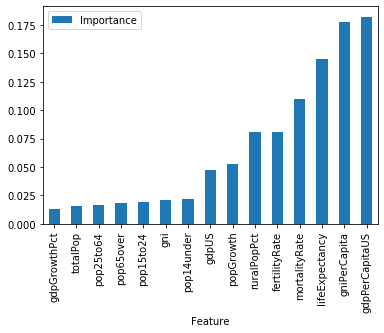

In [22]:
rf = RandomForestRegressor(max_features="sqrt")
# no need to scale for random forest

importances = [0 for i in range(len(Xtrain.columns))]

iterations = 1000
for i in range(iterations):
    rf.fit(Xtrain, ytrain)
    importances += rf.feature_importances_

importances = importances / iterations
print(len(importances))
print(len(Xtrain.columns))
importances = pd.DataFrame({'Feature':Xtrain.columns,'Importance':importances})
importances.sort_values(by='Importance').set_index('Feature').plot.bar()

In [23]:
most_important = importances[importances["Importance"] > .025]
best_features = list(most_important["Feature"])
best_features.append('happinessScore')
best_features

['fertilityRate',
 'lifeExpectancy',
 'mortalityRate',
 'popGrowth',
 'ruralPopPct',
 'gdpUS',
 'gdpPerCapitaUS',
 'gniPerCapita',
 'happinessScore']

These feature importance scores match my intuition.  It makes sense to me that features like GNI Per Capita, life expectancy, and mortiality rate are more important than features like gdp growth and gdp.

In the cell below, I'm going to compare and contrast the model with all of the features to one with only the most important features.

In [24]:
errs = pd.Series()

Xtrain_best = df_unesco_train[best_features]
Xtrain_best = Xtrain_best.dropna()
ytrain_best = Xtrain_best["happinessScore"]
Xtrain_best.drop("happinessScore", axis=1, inplace=True)

def tryModel(Xtrain, ytrain):
    cv_errs = -cross_val_score(rf, X=Xtrain, y=ytrain,
                             scoring="neg_mean_squared_error", cv=10)
  
    return np.sqrt(cv_errs.mean())

iterations = 10
all_rmse = 0
best_rmse = 0

for i in range(iterations):
    all_rmse += tryModel(Xtrain, ytrain)
    best_rmse += tryModel(Xtrain_best, ytrain_best)
   
errs['All features'] = all_rmse/iterations
errs['Best features'] = best_rmse/iterations
errs

All features     0.605877
Best features    0.618018
dtype: float64

In [25]:
iterations = 30
errs = {}
for i in range(iterations):
    rmses = []
    rmses.append(tryModel(Xtrain, ytrain))
    rmses.append(tryModel(Xtrain_best, ytrain_best))
    errs[i] = rmses
   

errs = pd.DataFrame(errs)
errs = errs.rename({0: "All features", 1: "Best features"})
errs = errs.transpose()
errs.head()

,All features,Best features
0,0.588587,0.593501
1,0.587106,0.605164
2,0.603534,0.609090
3,0.590015,0.625015
4,0.568005,0.619609


In [26]:
%%capture 
!pip install scikit-posthocs

Post-hoc pairwise test with bonferroni multiple test correction to test is there is a statistically significant difference between the model with all features and the model with the "best" features

In [27]:
import scikit_posthocs as sp

a = sp.posthoc_ttest(errs.transpose().values, p_adjust = 'bonferroni')
d = pd.DataFrame(a, columns=errs.columns,index=errs.columns)
display(d)
print(errs.mean().sort_values())

,All features,Best features
All features,-1.000000,0.020131
Best features,0.020131,-1.000000


All features     0.599885
Best features    0.608485
dtype: float64


A large p-value (> alpha = .05) indicates that there is no statstically significant different between the two models.  Because of this, I'm going to use the model with less features for the sake of simplicity.  Finally, I'm going to remove variables that are highly correlated. 

In [28]:
best_features_no_labels = best_features.copy()
best_features_no_labels.remove("happinessScore")
print("Final features:")
best_features

Final features:


['fertilityRate',
 'lifeExpectancy',
 'mortalityRate',
 'popGrowth',
 'ruralPopPct',
 'gdpUS',
 'gdpPerCapitaUS',
 'gniPerCapita',
 'happinessScore']

In [31]:
df = df_unesco.copy()
df = df[df["fertilityRate"] > 0]
df = df[df["lifeExpectancy"] > 0]
df = df[df["mortalityRate"] > 0]
df = df[df["popGrowth"] > 0]
df = df[df["ruralPopPct"] > 0]
df = df[df["gni"] > 0]
df = df[df["gdpPerCapitaUS"] > 0]
df = df[df["totalPop"] > 0]

# try to fill missing values as best as possible
for i, row in df_unesco.iterrows():
    if row["gdpPerCapitaUS"] <= 0:
        df_unesco.at[i, "gdpPerCapitaUS"] = row["gdpUS"]/row["totalPop"]
    if row["gniPerCapita"] <= 0:
        df_unesco.at[i, "gniPerCapita"] = row["gni"]/row["totalPop"]


In [32]:
Xtrain_final = df_unesco_train[best_features]
Xtrain_final = Xtrain_final.dropna()
ytrain_final = Xtrain_final["happinessScore"]
Xtrain_final.drop("happinessScore", axis=1, inplace=True)

Xtest = df[best_features_no_labels]
Xtest = Xtest.dropna()
rf = RandomForestRegressor(max_features="sqrt")
rf.fit(Xtrain_final, ytrain_final)

def tryModel():
    cv_errs = -cross_val_score(rf, X=Xtrain_final, y=ytrain_final,
                             scoring="neg_mean_squared_error", cv=10)
    return np.sqrt(cv_errs.mean())

print("Final estimated test rmse: ", tryModel())

ytest = rf.predict(Xtest)
Xtest["happinessScore"] = ytest

Final estimated test rmse:  0.6029673623668833


In [34]:
Xtest.to_csv("unesco_with_predictions.csv")